In [1]:
import os 
os.chdir('..')

In [2]:
import numpy as np
import pandas as pd
from loguru import logger
import matplotlib.pyplot as plt
import seaborn as sns

from models.cluster import KMeansClusterModel

from utils.load import load_sequences
from utils.pitch import extract_pitch_based_features
from utils.pitch import plot_pca_variance
from utils.pitch import plot_clusters

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [3]:
def main():

    # extract sequences
    sequences_df = load_sequences("data/sequences_old")
    records = []

    # generate feature

    for idx, row in sequences_df.iterrows():
        seq = row['sequence']
        features = extract_pitch_based_features(seq, max_interval=12)

        records.append({
            "id": idx,
            "features": features,
            "path": row['path']
        })

    features_df = pd.DataFrame(records, index=[r['id'] for r in records])
    features_df.sort_index(inplace=True)

    # apply pca

    X = np.vstack(features_df["features"].values)

    scaler = StandardScaler()
    X_std = scaler.fit_transform(X)

    pca = PCA(n_components=0.95, random_state=42)   # keep 95% of variance
    X_pca = pca.fit_transform(X_std)
    logger.info(f"PCA reduced from {X.shape[1]} → {X_pca.shape[1]} dimensions "
                f"({pca.explained_variance_ratio_.sum():.2%} variance kept)")

    plot_pca_variance(pca)

    model = KMeansClusterModel(n_clusters=5, max_iters=300, random_state=42)
    model.fit(X_pca)
    labels = model.labels_

    # Attach to your features_df
    features_df["cluster"] = labels
    logger.info(f"Cluster distribution:\n{features_df['cluster'].value_counts()}")
    plot_clusters(X_pca, labels, title="K-Means Cluster on PCA Features")


2025-11-11 00:23:44.029 | INFO     | utils.load:load_sequences:59 - Loading sequences from data/sequences_old with extension .npy
Loading sequences: 323it [00:00, 2974.91it/s]
2025-11-11 00:23:44.153 | SUCCESS  | utils.load:load_sequences:81 - Loaded 323 sequences from data/sequences_old
2025-11-11 00:23:44.871 | INFO     | __main__:main:31 - PCA reduced from 169 → 89 dimensions (95.15% variance kept)


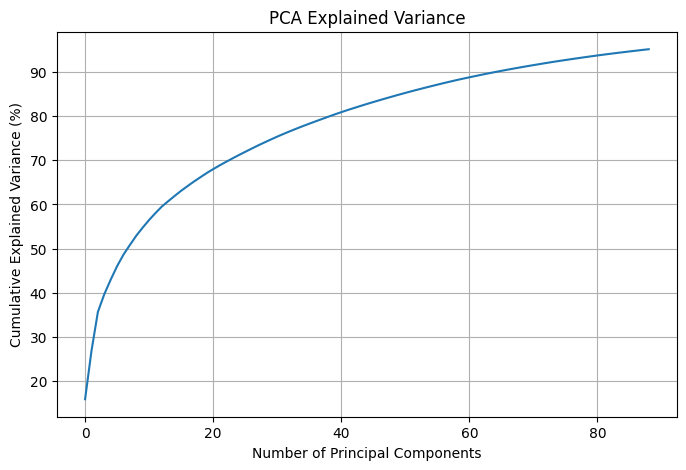

2025-11-11 00:23:44.981 | INFO     | __main__:main:42 - Cluster distribution:
cluster
3    118
2    106
4     77
0     21
1      1
Name: count, dtype: int64


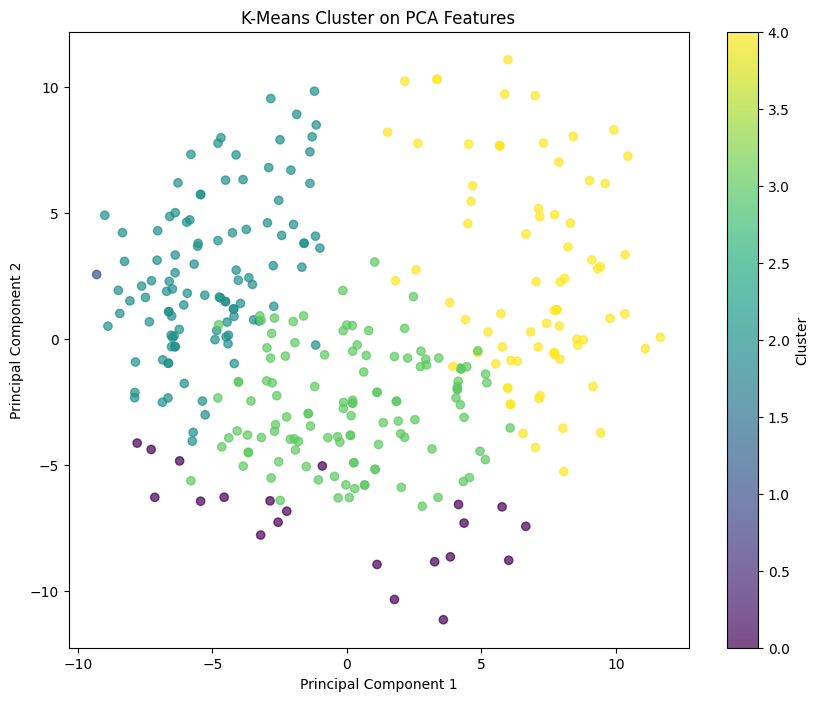

In [4]:
main()